# Brn2-2A-mRuby2 MOI titrate

Notes:

1. Have both singlets and mRuby2+ (mRuby2 vs. iRFP670 gate)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib
from scipy.optimize import curve_fit

# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# MOI calculation

## MOI calc from batch 1 on 4/16

Text(0.5, 0, 'µL of virus')

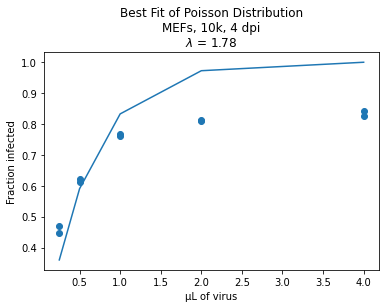

In [2]:
data = {'virus_vol': [4, 2, 1, 0.5, 0.25, 4, 2, 1, 0.5, 0.25,],
        'replicate': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
        'frac_infected': [.842, .814, .762, .621, .446, .825, .810, .766, .612, .469],}

df = pd.DataFrame(data)


def poisson_model(virus_vol, TUratio):
    # MOI = TUratio*virus_vol
    return 1 - np.exp(-TUratio * virus_vol)

popt, _ = curve_fit(
    poisson_model,
    df["virus_vol"],
    df["frac_infected"],
    p0=0.5,
    bounds=(0, np.inf),
)

df = df.sort_values("virus_vol")
plt.scatter(df["virus_vol"], df["frac_infected"])
plt.plot(df["virus_vol"], poisson_model(df["virus_vol"], *popt))

plt.title(f"Best Fit of Poisson Distribution\nMEFs, 10k, 4 dpi\n$\lambda$ = {popt[0]:.2f}")
# plt.xscale("log")
plt.ylabel("Fraction infected")
plt.xlabel("µL of virus")


Text(0.5, 0, 'µL of virus')

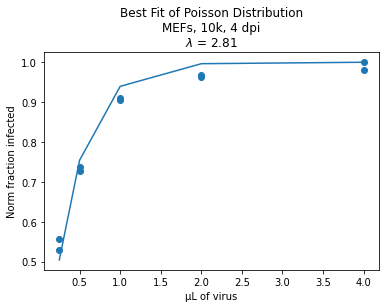

In [3]:
df['norm_frac_infected'] = df['frac_infected']/np.max(df['frac_infected'])

popt2, _ = curve_fit(
    poisson_model,
    df["virus_vol"],
    df["norm_frac_infected"],
    p0=0.5,
    bounds=(0, np.inf),
)

df = df.sort_values("virus_vol")
plt.scatter(df["virus_vol"], df["norm_frac_infected"])
plt.plot(df["virus_vol"], poisson_model(df["virus_vol"], *popt2))

plt.title(f"Best Fit of Poisson Distribution\nMEFs, 10k, 4 dpi\n$\lambda$ = {popt2[0]:.2f}")
# plt.xscale("log")
plt.ylabel("Norm fraction infected")
plt.xlabel("µL of virus")

# 4 dpi

## Load data

In [4]:
# Directories
base_datadir = rd.datadir/'2024.07.07_Brn2-MOI-titrate_4dpi_1-4'
figpath = '../figures/fig4/'

# List of data folder names
dir_list = ['2024.07.07_Brn2-MOI-titrate_4dpi_1-2', '2024.07.09_Brn2-MOI-titrate_4dpi_3-4']

ctrl_list = ['Ctrl-mRuby2', 'Ctrl-neg', 'Ctrl-puro']
cond_list = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)', 'Ctrl-puro']

# Store all data in list of dfs which will be converted to df at end
data_4dpi_singlets_all = list()
data_4dpi_mRuby2_all = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):
    
     # Load as df and note header is on 0th row
    df_singlets = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/dir_name/'well_metadata.yaml')
    df_mRuby2 = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_mRuby2', base_datadir/dir_name/'well_metadata.yaml')

    data_4dpi_singlets_all.append(df_singlets)
    data_4dpi_mRuby2_all.append(df_mRuby2)
    
    
# Convert list of dfs into single df
data_4dpi_singlets_all = pd.concat(data_4dpi_singlets_all, ignore_index=True)
data_4dpi_mRuby2_all = pd.concat(data_4dpi_mRuby2_all, ignore_index=True)
data_4dpi_singlets_all['gate'] = 'singlets'
data_4dpi_mRuby2_all['gate'] = 'mRuby2+'

# Remove negative data
data_4dpi_singlets_all = data_4dpi_singlets_all.loc[
    (data_4dpi_singlets_all['eGFP-A'] > 0) &
    (data_4dpi_singlets_all['CellTrace™ Violet-A'] > 0) &
    (data_4dpi_singlets_all['mRuby2-A'] > 0)
]
data_4dpi_mRuby2_all = data_4dpi_mRuby2_all.loc[
    (data_4dpi_mRuby2_all['eGFP-A'] > 0) &
    (data_4dpi_mRuby2_all['CellTrace™ Violet-A'] > 0) &
    (data_4dpi_mRuby2_all['mRuby2-A'] > 0)
]

# Separate out ctrl and sample data
data_4dpi_singlets_ctrl = data_4dpi_singlets_all[ data_4dpi_singlets_all['cond'].isin(ctrl_list) ]
data_4dpi_singlets = data_4dpi_singlets_all[ data_4dpi_singlets_all['cond'].isin(cond_list) ]
data_4dpi_mRuby2_ctrl = data_4dpi_mRuby2_all[ data_4dpi_mRuby2_all['cond'].isin(ctrl_list) ]
data_4dpi_mRuby2 = data_4dpi_mRuby2_all[ data_4dpi_mRuby2_all['cond'].isin(cond_list) ]

## Look at mRuby2

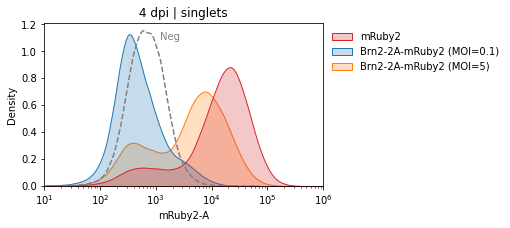

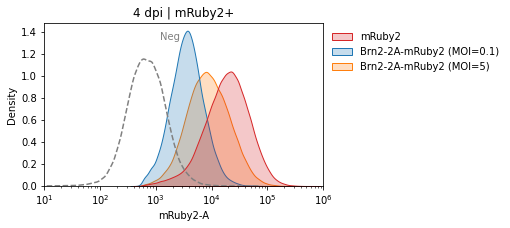

In [5]:
# What to plot
for gate in ['singlets', 'mRuby2+']:
    if gate == 'singlets':
        df = data_4dpi_singlets
    elif gate == 'mRuby2+':
        df = data_4dpi_mRuby2

    # Plot mRuby2-A
    x = 'mRuby2-A'
    hue = 'cond'
    hue_order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
    labels  = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
    palette = {
        'mRuby2': 'tab:red', 
        'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
        'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    f = sns.kdeplot(data=df,
        ax=ax, x=x, hue=hue,
        hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        palette=palette,
        fill=True)

    # Adjust labels
    sns.move_legend(ax,
        title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

    # Plot neg ctrl
    sns.kdeplot(data=data_4dpi_singlets_ctrl[(data_4dpi_singlets_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax.annotate('Neg', (0.45, 0.9), color='grey', xycoords='axes fraction', ha='center')
        
    # Adjust limits
    mRuby2_lim = (10, 1*10**6)
    ax.set_xlim(mRuby2_lim)

    # Save fig
    ax.set_title(f'4 dpi | {gate}')

What is mRuby2+ %?

In [6]:
# Calculate CTV populations using these metrics
group = ['rep', 'cond']
count_df_reps = data_4dpi_mRuby2.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count')
totalcount_df_reps = data_4dpi_singlets.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count')
mRuby2_percent_4dpi_reps = (count_df_reps*100/totalcount_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='percent')

# # Collapse bio reps
mRuby2_percent_4dpi = mRuby2_percent_4dpi_reps.groupby(group).mean().reset_index()

[Text(0, 0, 'mRuby2'),
 Text(1, 0, 'Brn2\n(MOI=0.1)'),
 Text(2, 0, 'Brn2\n(MOI=5)')]

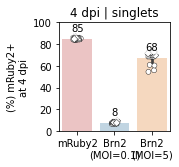

In [7]:
# General plotting params
x = 'cond'
y = 'percent'
order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

# Plot
sns.barplot(
    ax=ax, data=mRuby2_percent_4dpi_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(mRuby2_percent_4dpi_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=mRuby2_percent_4dpi_reps[mRuby2_percent_4dpi_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
# Label
ax.set_title(f'4 dpi | singlets')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) mRuby2+\nat 4 dpi')
ax.set_yticks(np.arange(0, 101, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

ax.set_xticklabels([label_dict[label] for label in order])

#### Compare to ctrl

In [8]:
# Calculate CTV populations using these metrics
group = ['rep', 'cond']
ctrl_count_df_reps = data_4dpi_mRuby2_ctrl.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count') # Puts 0 if none rather than dropping row
ctrl_totalcount_df_reps = data_4dpi_singlets_ctrl.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count') # Puts 0 if none rather than dropping row
ctrl_mRuby2_percent_4dpi_reps = (ctrl_count_df_reps*100/ctrl_totalcount_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='percent')

# # Collapse bio reps
ctrl_mRuby2_percent_4dpi_reps = ctrl_mRuby2_percent_4dpi_reps.groupby(group).mean().reset_index()

[Text(0, 0, 'Ctrl-\npuro'),
 Text(1, 0, 'Ctrl-\nneg'),
 Text(2, 0, 'Ctrl-\nmRuby2')]

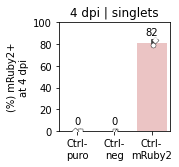

In [12]:
# General plotting params
x = 'cond'
y = 'percent'
order = ['Ctrl-puro', 'Ctrl-neg', 'Ctrl-mRuby2']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'Ctrl-neg': 'black',
    'Ctrl-mRuby2': 'tab:red',}
ctrl_label_dict = {
    'Ctrl-puro': 'Ctrl-\npuro',
    'Ctrl-neg': 'Ctrl-\nneg',
    'Ctrl-mRuby2': 'Ctrl-\nmRuby2',}

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

# Plot
sns.barplot(
    ax=ax, data=ctrl_mRuby2_percent_4dpi_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(ctrl_mRuby2_percent_4dpi_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=ctrl_mRuby2_percent_4dpi_reps[ctrl_mRuby2_percent_4dpi_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
# Label
ax.set_title(f'4 dpi | singlets')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) mRuby2+\nat 4 dpi')
ax.set_yticks(np.arange(0, 101, 20))
# ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

ax.set_xticklabels([ctrl_label_dict[label] for label in order])

## Look at total counts at 4 dpi

In [13]:
group = ['gate', 'cond', 'rep',]

# Get total counts by gate
mRuby2_count_df_reps = data_4dpi_mRuby2.groupby([*group, 'well'])['FSC-A'].count().reset_index(name='Total count')
total_count_df_reps = data_4dpi_singlets.groupby([*group, 'well'])[ 'FSC-A'].count().reset_index(name='Total count')
# Merge total and mRuby2+ counts
total_count_4dpi_bothgates_reps = pd.concat([total_count_df_reps, mRuby2_count_df_reps])
# Collapse bio reps
total_count_4dpi_bothgates = total_count_4dpi_bothgates_reps.groupby(group).mean().reset_index()


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1)_singlets vs. Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+: t-test independent samples, P_val:3.529e-05 t=1.090e+01
mRuby2_singlets vs. mRuby2_mRuby2+: t-test independent samples, P_val:1.665e-01 t=1.574e+00
Brn2-2A-mRuby2 (MOI=5)_singlets vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:8.550e-02 t=2.056e+00
Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:7.459e-04 t=-6.299e+00


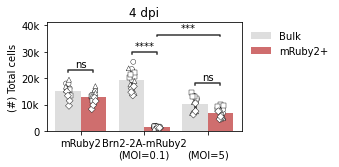

In [15]:
# Plotting params
x = 'cond'
y = 'Total count'
hue = 'gate'
units = 'rep'

order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
hue_order = ['singlets', 'mRuby2+']
label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'\n(MOI=5)'}


palette = {'singlets': 'lightgrey',
            'mRuby2+': 'tab:red'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

for (i, rep) in enumerate(total_count_4dpi_bothgates_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=total_count_4dpi_bothgates_reps[total_count_4dpi_bothgates_reps.rep == rep],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'singlets': 'white', 'mRuby2+': 'white'}, size=5,
        edgecolor='black', linewidth=0.4)

# Plot as box
sns.barplot(ax=ax,
    data=total_count_4dpi_bothgates_reps, 
    x=x, y=y, hue=hue, units=units,
    order=order, hue_order=hue_order, 
    palette=palette, alpha=0.75)

# Adjust labels
lmap = {'singlets':'Bulk', 'mRuby2+':'mRuby2+'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_xlabel('')
ax.yaxis.set_label_text('(#) Total cells')
# ax.set_yticks(np.arange(0, 41, 10))
ax.set_xticklabels([label_dict[label] for label in order])
ax.set_ylim([0, 30e3])
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'singlets'), (cond, 'mRuby2+')) for cond in order]
pairs.append((('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+')))

annot = Annotator(ax=ax,
    data=total_count_4dpi_bothgates, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

plt.title('4 dpi')
# plt.savefig(figpath + '4dpi_totalcount-singlets-v-mRuby2+.svg', bbox_inches='tight')

## Look at CellTrace

### In singlets

In [16]:
# Get CTV-low threshold for each rep s.t.
# CTV_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi_singlets.rep.unique()
CTV_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTV_low_thresh_list[i] = np.percentile(
        data_4dpi_singlets_ctrl.loc[(data_4dpi_singlets_ctrl['cond'] == 'Ctrl-puro') &
            (data_4dpi_singlets_ctrl['rep'] == rep)
        ]['CellTrace™ Violet-A'], 20)
    
# Categorize based on CTV for each rep
data_4dpi_singlets.loc[:, 'CTV_cat'] = 'CTV-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi_singlets.loc[
        (data_4dpi_singlets['rep'] == rep_list[i]) &
        (data_4dpi_singlets['CellTrace™ Violet-A'] > CTV_low_thresh_list[i]),
        'CTV_cat'] = 'non-CTV-low'
    
# Calculate CTV populations using these metrics
group = ['gate', 'cond', 'rep']
count_df_reps = data_4dpi_singlets.groupby([*group, 'well', 'CTV_cat'])[
    'FSC-A'].count().rename('count') 
CTV_percent_4dpi_reps = (count_df_reps*100/count_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='HyperP percent')
CTV_hyperP_count_4dpi_reps = (count_df_reps).reset_index(name='HyperP count')
data_4dpi_CTV_singlets_reps = pd.merge(CTV_percent_4dpi_reps, CTV_hyperP_count_4dpi_reps)

# Extract just the hyperP
data_4dpi_CTV_singlets_reps = data_4dpi_CTV_singlets_reps.loc[(data_4dpi_CTV_singlets_reps['CTV_cat'] == 'CTV-low')]
# Collapse bio reps
data_4dpi_CTV_singlets = data_4dpi_CTV_singlets_reps.groupby(group).mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


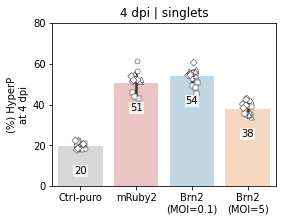

In [17]:
# General plotting params
x = 'cond'
y = 'HyperP percent'
order = ['Ctrl-puro', 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot
sns.barplot(
    ax=ax, data=data_4dpi_CTV_singlets_reps,
    x=x, y=y,
    order=order, units=units,
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(data_4dpi_CTV_singlets_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_4dpi_CTV_singlets_reps[data_4dpi_CTV_singlets_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
ax.set_title(f'4 dpi | singlets')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.set_yticks(np.arange(0, 90, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=-30)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

[Text(0, 0, 'Ctrl-puro'),
 Text(1, 0, 'mRuby2'),
 Text(2, 0, 'Brn2\n(MOI=0.1)'),
 Text(3, 0, 'Brn2\n(MOI=5)')]

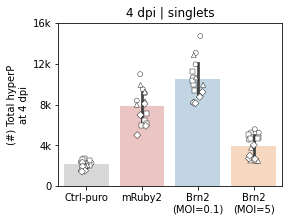

In [18]:
# General plotting params
x = 'cond'
y = 'HyperP count'
order = ['Ctrl-puro', 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot
sns.barplot(
    ax=ax, data=data_4dpi_CTV_singlets_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(data_4dpi_CTV_singlets_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_4dpi_CTV_singlets_reps[data_4dpi_CTV_singlets_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
ax.set_title(f'4 dpi | singlets')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
ax.set_yticks(np.arange(0, 17*10**3, 4*10**3))
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)
ax.set_xticklabels([label_dict[label] for label in order])

### in mRuby2+

In [19]:
# Categorize mRuby2 cells as hyperP or not
data_4dpi_mRuby2.loc[:, 'CTV_cat'] = 'CTV-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi_mRuby2.loc[
        (data_4dpi_mRuby2['rep'] == rep_list[i]) &
        (data_4dpi_mRuby2['CellTrace™ Violet-A'] > CTV_low_thresh_list[i]),
        'CTV_cat'] = 'non-CTV-low'
    
# Calculate CTV populations for mRuby2+ cells
group = ['gate', 'cond', 'rep']
count_df_reps = data_4dpi_mRuby2.groupby([*group, 'well', 'CTV_cat'])[
    'FSC-A'].count().rename('count') 
mRuby2_CTV_percent_4dpi_reps = (count_df_reps*100/count_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='HyperP percent')
mRuby2_CTV_hyperP_count_4dpi_reps = (count_df_reps).reset_index(name='HyperP count')

# Extract just the hyperP
mRuby2_CTV_percent_4dpi_reps = mRuby2_CTV_percent_4dpi_reps.loc[(mRuby2_CTV_percent_4dpi_reps['CTV_cat'] == 'CTV-low')]
mRuby2_CTV_hyperP_count_4dpi_reps = mRuby2_CTV_hyperP_count_4dpi_reps.loc[(mRuby2_CTV_hyperP_count_4dpi_reps['CTV_cat'] == 'CTV-low')]
data_4dpi_CTV_mRuby2_reps = mRuby2_CTV_percent_4dpi_reps.merge(mRuby2_CTV_hyperP_count_4dpi_reps)

# Merge mRuby2+ and singlet dataframes together and get rid of Ctrl-puro (no mRuby2+)
# data_4dpi_CTV_bothgates_reps = data_4dpi_CTV_singlets_reps.merge(data_4dpi_CTV_mRuby2_reps)
data_4dpi_CTV_bothgates_reps = pd.concat([data_4dpi_CTV_singlets_reps, data_4dpi_CTV_mRuby2_reps])
data_4dpi_CTV_bothgates_reps = data_4dpi_CTV_bothgates_reps.loc[data_4dpi_CTV_bothgates_reps.cond != 'Ctrl-puro']

# Collapse bio reps
data_4dpi_CTV_bothgates = data_4dpi_CTV_bothgates_reps.groupby(group).mean(['HyperP percent', 'HyperP count']).reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


[Text(0, 0, 'Ctrl-puro'),
 Text(1, 0, 'mRuby2'),
 Text(2, 0, 'Brn2\n(MOI=0.1)'),
 Text(3, 0, 'Brn2\n(MOI=5)')]

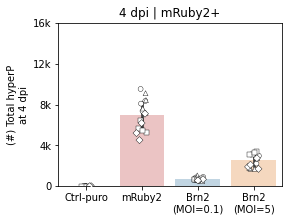

In [20]:
# General plotting params
x = 'cond'
y = 'HyperP count'
order = ['Ctrl-puro', 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot
sns.barplot(
    ax=ax, data=data_4dpi_CTV_mRuby2_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(data_4dpi_CTV_mRuby2_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_4dpi_CTV_mRuby2_reps[data_4dpi_CTV_mRuby2_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
ax.set_title(f'4 dpi | mRuby2+')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
ax.set_yticks(np.arange(0, 17*10**3, 4*10**3))
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)
ax.set_xticklabels([label_dict[label] for label in order])
# plt.savefig(figpath + '4dpi_hyperP_mRuby2+_count.svg', bbox_inches='tight') 

[Text(0, 0, 'Ctrl-puro'),
 Text(1, 0, 'mRuby2'),
 Text(2, 0, 'Brn2\n(MOI=0.1)'),
 Text(3, 0, 'Brn2\n(MOI=5)')]

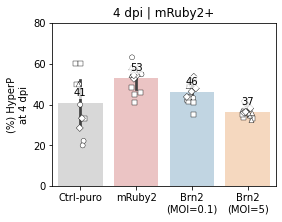

In [21]:
# General plotting params
x = 'cond'
y = 'HyperP percent'
order = ['Ctrl-puro', 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot
sns.barplot(
    ax=ax, data=data_4dpi_CTV_mRuby2_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(data_4dpi_CTV_mRuby2_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_4dpi_CTV_mRuby2_reps[data_4dpi_CTV_mRuby2_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
ax.set_title(f'4 dpi | mRuby2+')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.set_yticks(np.arange(0, 90, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)
ax.set_xticklabels([label_dict[label] for label in order])

### CellTrace of bulk

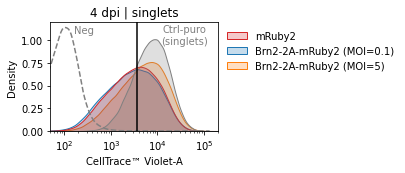

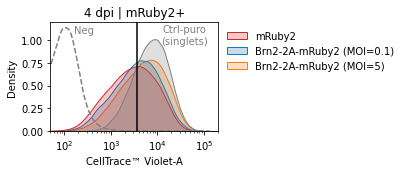

In [22]:
# What to plot
for gate in ['singlets', 'mRuby2+']:
    if gate == 'singlets':
        df = data_4dpi_singlets
    elif gate == 'mRuby2+':
        df = data_4dpi_mRuby2

    # Plot CTV
    x = 'CellTrace™ Violet-A'
    hue = 'cond'
    hue_order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
    labels  = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
    palette = {
        'mRuby2': 'tab:red', 
        'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
        'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
    
    order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.kdeplot(data=df,
        ax=ax, x=x, hue=hue,
        hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        palette=palette,
        fill=True)

    # Adjust labels
    s = sns.move_legend(ax,
        title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

    # Plot neg ctrl
    sns.kdeplot(data=data_4dpi_singlets_ctrl[(data_4dpi_singlets_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax.annotate('Neg', (0.2, 0.9), color='grey', xycoords='axes fraction', ha='center')

    # Plot puro ctrl
    sns.kdeplot(data=data_4dpi_singlets_ctrl[(data_4dpi_singlets_ctrl['cond'] == 'Ctrl-puro')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=True)
    ax.annotate('Ctrl-puro\n(singlets)', (0.8, 0.8), color='grey', xycoords='axes fraction', ha='center')
        
    # Adjust limits
    CTV_lim = (50, 2*10**5)
    ax.set_xlim(CTV_lim)
    # Add CTV thresh
    rep = 1 # Which rep to plot
    CTV_low_thresh = CTV_low_thresh_list[rep-1]
    ax.axvline(CTV_low_thresh, 0, 1, color='black')

    # Save fig
    ax.set_title(f'4 dpi | {gate}')

### Compare CTV vs. mRuby2

#### Plot hyperP count/percent vs. mRuby2/bulk gates

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1)_singlets vs. Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+: t-test independent samples, P_val:4.054e-02 t=2.602e+00
mRuby2_singlets vs. mRuby2_mRuby2+: t-test independent samples, P_val:5.719e-01 t=-5.977e-01
Brn2-2A-mRuby2 (MOI=5)_singlets vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:4.338e-01 t=8.386e-01
Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:1.006e-02 t=3.702e+00
mRuby2_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:1.405e-03 t=5.581e+00


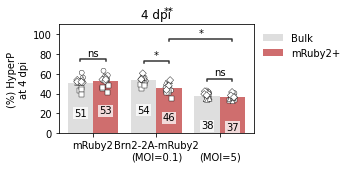

In [23]:
# Plotting params
x = 'cond'
y = 'HyperP percent'
hue = 'gate'

order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
hue_order = ['singlets', 'mRuby2+']
label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'\n(MOI=5)'}


palette = {'singlets': 'lightgrey',
            'mRuby2+': 'tab:red'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

for (i, rep) in enumerate(data_4dpi_CTV_bothgates_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_4dpi_CTV_bothgates_reps[data_4dpi_CTV_bothgates_reps.rep == rep],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'singlets': 'white', 'mRuby2+': 'white'}, size=5,
        edgecolor='black', linewidth=0.4)

# Plot as box
sns.barplot(ax=ax,
    data=data_4dpi_CTV_bothgates_reps, 
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order, 
    palette=palette, alpha=0.75)

# Adjust labels
lmap = {'singlets':'Bulk', 'mRuby2+':'mRuby2+'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=-35)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.set_yticks(np.arange(0, 101, 20))
ax.set_ylim(0, 100)
ax.set_xticklabels([label_dict[label] for label in order])

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'singlets'), (cond, 'mRuby2+')) for cond in order]
pairs.append((('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+')))
pairs.append((('mRuby2', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+')))

plt.title('4 dpi')
# plt.savefig(figpath + '4dpi_CTV-singlets-v-mRuby2+_alt.svg', bbox_inches='tight')

annot = Annotator(ax=ax,
    data=data_4dpi_CTV_bothgates, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)
ax.set_ylim(0, 110)
plt.title('4 dpi')
# plt.savefig(figpath + 'SI/4dpi_hyperPpercent-singlets-v-mRuby2+_alt.svg', bbox_inches='tight')

#### Plot total count vs. percent in bulk vs. mRuby2+?

In [24]:
# Add ctrl-puro non-mRuby2 cells
df = pd.concat([data_4dpi_CTV_bothgates_reps,
                data_4dpi_CTV_singlets_reps.loc[data_4dpi_CTV_singlets_reps.cond == 'Ctrl-puro']])

# Calc mean and SEM for each cond
group = ['gate', 'cond', 'rep']
data_4dpi_CTV_bothgates_mean = df.groupby(group).mean().reset_index()
data_4dpi_CTV_bothgates_SEM = df.groupby(group).sem().reset_index()


# Exponential model
def model(x, y_init, k, C):
    return y_init*np.exp((k*x)) + C


# Fit model with just singlets
gate = 'singlets'
xdata = data_4dpi_CTV_bothgates_mean[data_4dpi_CTV_bothgates_mean.gate == gate]['HyperP percent']
ydata = data_4dpi_CTV_bothgates_mean[data_4dpi_CTV_bothgates_mean.gate == gate]['HyperP count']

popt, pcov = curve_fit(
    model, xdata=xdata, ydata=ydata,
    p0=[1, .05, 0], bounds=([0, 0, -10**5], [10**5, 1**2, 10**5]))

display(popt)

y_pred = model(xdata, *popt)
y_avg = np.mean(ydata)
SSres = np.sum((ydata-y_pred)**2)
SStot = np.sum((ydata-y_avg)**2)
Rsq = 1 - SSres/SStot

print(Rsq)

array([ 9.40381602e+02,  4.31035616e-02, -2.38898855e+02])

0.8346947024115302


In [25]:
nboot = 10**4
params_all = np.zeros((len(popt), nboot))
x_all = np.zeros((len(xdata), nboot))
y_all = np.zeros((len(xdata), nboot))

########## ACTUAL ##########
x_CI = np.linspace(0, 100)
y_CI_all = np.zeros((len(x_CI), nboot))
############################

# Just fit singlets
gate = 'singlets'
data_singlets = data_4dpi_CTV_bothgates_mean.loc[data_4dpi_CTV_bothgates_mean.gate == gate]

for i in np.arange(nboot):

    # Sample with replacement and fit
    data = data_singlets.sample(n=len(xdata), replace=True)
    x = 'HyperP percent'
    y = 'HyperP count'

    try:
        popt_i, pcov_i = curve_fit(
            model, xdata=data[x], ydata=data[y],
            p0=[1e3, 1e-1, -5e3], bounds=([0, 0, -10**5], [10**6, 1**2, 10**5]))
    except RuntimeError:
       print("Couldn't solve, increasing max number of function evals")
       popt_i, pcov_i = curve_fit(
            model, xdata=data[x], ydata=data[y],
            p0=[1e3, 1e-1, -5e3], bounds=([0, 0, -10**5], [10**6, 1**2, 10**5]), maxfev=5000)
    
    
    # Store data
    params_all[:, i] = popt_i
    x_all[:, i] = data[x]
    y_all[:, i] = model(data[x], *popt_i)
    ########## ACTUAL ##########
    y_CI_all[:, i] = model(x_CI, *popt_i)
    ########## ACTUAL ##########


# Extract parameters and values
y_init = params_all[0::3].flatten()
k = params_all[1::3].flatten()
C = params_all[2::3].flatten()

x_all = np.reshape(x_all, (x_all.size, 1))
y_all = np.reshape(y_all, (y_all.size, 1))
# Convert (x, y) data to df
bootstrap_all = pd.DataFrame(np.hstack((x_all, y_all)), columns=['x', 'y'])

Couldn't solve, increasing max number of function evals
Couldn't solve, increasing max number of function evals


In [26]:
# Make 95% CI
CI = 95
# do it
y_lb = np.zeros(len(x_CI))
y_ub = np.zeros(len(x_CI))
for (i, x_curr) in enumerate(x_CI):
    y_curr =  y_CI_all[i]
    y_lb[i] = np.percentile(y_curr, (100-CI)/2)
    y_ub[i] = np.percentile(y_curr, 100-(100-CI)/2)

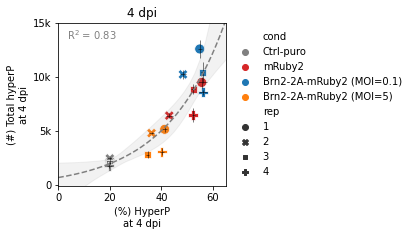

In [27]:
# Plotting params
x = 'HyperP percent'
y = 'HyperP count'
style = 'rep'
hue = 'cond'
hue_order = ['Ctrl-puro', 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
labels  = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
palette = {
    'Ctrl-puro': 'grey', 
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

gate = 'singlets'
df_mean = data_4dpi_CTV_bothgates_mean.loc[data_4dpi_CTV_bothgates_mean.gate == gate]
df_SEM = data_4dpi_CTV_bothgates_SEM.loc[data_4dpi_CTV_bothgates_SEM.gate == gate]
            
f = sns.scatterplot(ax=ax,
    data=df_mean,
    x=x, y=y, hue=hue, hue_order=hue_order,
    style=style,
    s=100, palette=palette)
ax.errorbar(x=df_mean[x], y=df_mean[y],
            xerr=df_SEM[x], yerr=df_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)

# Plot model fit
x_line = np.linspace(0, 100, 10**4)
y_line = model(x_line, *popt)
plt.plot(x_line, y_line, c='grey', ls='--')
ax.fill_between(x_CI, y_lb, y_ub, color='grey', alpha=0.1) # CI
plt.annotate('R$^2$ = {:.2f}'.format(Rsq), (0.2, 0.9), color='grey', xycoords='axes fraction', ha='center')


sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticks(np.arange(0, 110, 20))
ax.set_xlim((0, 65))
ax.set_yticks(np.arange(0, 20e3, 5e3))
ax.set_ylim((-1e2, 15*1e3))
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)
ax.xaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.yaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
plt.title('4 dpi')

# plt.savefig(figpath + 'SI/4dpi_hyperP_countvpercent.svg', bbox_inches='tight')

Look at CTV in bulk vs. mRuby2+ gated for low MOI

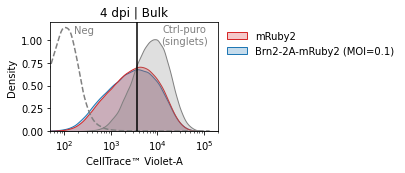

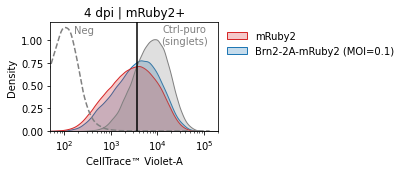

In [28]:
# What to plot
for gate in ['singlets', 'mRuby2+']:
    if gate == 'singlets':
        df = data_4dpi_singlets
    elif gate == 'mRuby2+':
        df = data_4dpi_mRuby2

    # Plot CTV
    x = 'CellTrace™ Violet-A'
    hue = 'cond'
    hue_order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)']
    labels  = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)']
    palette = {
        'mRuby2': 'tab:red', 
        'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
        'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.kdeplot(data=df,
        ax=ax, x=x, hue=hue, hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        palette=palette,
        fill=True)

    # Adjust labels
    s = sns.move_legend(ax,
        title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

    # Plot neg ctrl
    sns.kdeplot(data=data_4dpi_singlets_ctrl[(data_4dpi_singlets_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax.annotate('Neg', (0.2, 0.9), color='grey', xycoords='axes fraction', ha='center')

    # Plot puro ctrl
    sns.kdeplot(data=data_4dpi_singlets_ctrl[(data_4dpi_singlets_ctrl['cond'] == 'Ctrl-puro')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=True)
    ax.annotate('Ctrl-puro\n(singlets)', (0.8, 0.8), color='grey', xycoords='axes fraction', ha='center')

    # Add CTV thresh
    rep = 1 # Which rep to plot
    CTV_low_thresh = CTV_low_thresh_list[rep-1]
    ax.axvline(CTV_low_thresh, 0, 1, color='black')
        
    # Adjust limits
    CTV_lim = (50, 2*10**5)
    ax.set_xlim(CTV_lim)

    # Save fig
    if gate == 'singlets':
        ax.set_title('4 dpi | Bulk')
    else:
        ax.set_title(f'4 dpi | {gate}')
    # plt.savefig(figpath + f'SI/4dpi_CTV_dist-lowMOI_{gate}.svg', bbox_inches='tight')

Look at mean values

In [29]:
df = [data_4dpi_singlets, data_4dpi_mRuby2]
df = pd.concat(df, ignore_index=True)

group = ['gate', 'cond', 'rep']

# CTV
x = 'CellTrace™ Violet-A'
df_CTV_gmean_reps = df.groupby([*group, 'well'])[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')
df_CTV_gmean_reps.loc[:, 'log({})'.format(x+' (gmean)')] = np.log10(df_CTV_gmean_reps[x+' (gmean)'])

# mRuby2
x = 'mRuby2-A'
df_mRuby2_gmean_reps = df.groupby([*group, 'well'])[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')
df_mRuby2_gmean_reps.loc[:, 'log({})'.format(x+' (gmean)')] = np.log10(df_mRuby2_gmean_reps[x+' (gmean)'])

# Merge dfs
df_gmean_reps = pd.merge(df_CTV_gmean_reps, df_mRuby2_gmean_reps)

# Collapse to bio reps
df_gmean = df_gmean_reps.groupby(group).mean().reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1)_singlets vs. Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+: t-test independent samples, P_val:4.935e-03 t=-3.035e+00
mRuby2_singlets vs. mRuby2_mRuby2+: t-test independent samples, P_val:4.799e-01 t=7.154e-01
Brn2-2A-mRuby2 (MOI=5)_singlets vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:2.465e-01 t=-1.182e+00
Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:9.898e-05 t=-4.486e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


Text(0.5, 1.0, '4 dpi')

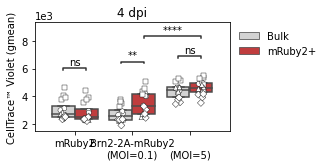

In [30]:
# Plotting params
x = 'cond'
y = 'CellTrace™ Violet-A'
hue = 'gate'

order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
hue_order = ['singlets', 'mRuby2+']
label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'\n(MOI=5)'}


palette = {'singlets': 'lightgrey',
            'mRuby2+': 'tab:red'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

# Plot log10 transformed -> well geometric means
for (i, rep) in enumerate(df_gmean_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=df_gmean_reps[df_gmean_reps.rep == rep],
        x=x, y=(y+' (gmean)'), hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'singlets': 'white', 'mRuby2+': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Plot as box
sns.boxplot(ax=ax,
    data=df_gmean_reps, 
    y = (y+' (gmean)'), #y='log({})'.format(y),
    x=x, hue=hue,
    order=order, hue_order=hue_order, 
    width=0.8, palette=palette, whis=0, showfliers=False)

# Adjust labels
lmap = {'singlets':'Bulk', 'mRuby2+':'mRuby2+'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_xlabel('')
ax.set_ylabel('CellTrace™ Violet (gmean)')
ax.set_xticklabels([label_dict[label] for label in order])
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
# ax.yaxis.set_major_formatter(k_formatter)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylim(1.5*10**3, 6*10**3)
ax.set_yticks(np.arange(2*10**3, 10*10**3, 2*10**3))

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'singlets'), (cond, 'mRuby2+')) for cond in order]
pairs.append((('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+')))
annot = Annotator(ax=ax,
    data=df_gmean_reps, pairs=pairs,
    x=x, y=(y+' (gmean)'), 
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.2)

plt.title('4 dpi')

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:6.666e-06 t=-1.453e+01


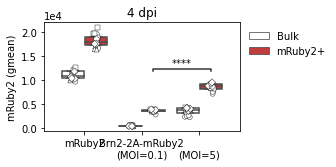

In [31]:
# Plotting params
x = 'cond'
y = 'mRuby2-A'
hue = 'gate'

order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
hue_order = ['singlets', 'mRuby2+']
label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'\n(MOI=5)'}

palette = {'singlets': 'white',
            'mRuby2+': 'tab:red'}

marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

for (i, rep) in enumerate(df_gmean_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=df_gmean_reps[df_gmean_reps.rep == rep],
        x=x, y=(y+' (gmean)'), hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'singlets': 'white', 'mRuby2+': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Plot as box
sns.boxplot(ax=ax,
    data=df_gmean_reps, 
    y = (y+' (gmean)'), #y='log({})'.format(y),
    x=x, hue=hue,
    order=order, hue_order=hue_order, 
    width=0.8, palette=palette, whis=0, showfliers=False)

# Adjust labels
lmap = {'singlets':'Bulk', 'mRuby2+':'mRuby2+'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_xlabel('')
ax.set_ylabel('mRuby2 (gmean)')
ax.set_xticklabels([label_dict[label] for label in order])
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Add in stats
# Pairs for stats comp
pairs = [(('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+'))]
annot = Annotator(ax=ax,
    data=df_gmean, pairs=pairs,
    x=x, y=(y+' (gmean)'), 
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

plt.title('4 dpi')
# plt.savefig(figpath + 'SI/4dpi_mRuby2-singlets-v-mRuby2+_alt.svg', bbox_inches='tight')

Plot against each other

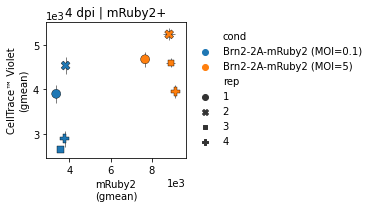

In [32]:
hue = 'cond'
x = 'mRuby2-A (gmean)'
y = 'CellTrace™ Violet-A (gmean)'
gate = 'mRuby2+'
hue_order = ['Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']

palette = {
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'Brn2-2A-mRuby2\n(MOI=5)'}

# Calc mean and SEM
df = df_gmean_reps.copy()
df = df[(df.gate == gate) & (df.cond != 'Ctrl-puro') & (df.cond != 'mRuby2')]
group = ['cond', 'rep']
df_mean = df.groupby(group).mean().reset_index()
df_SEM = df.groupby(group).sem().reset_index()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
sns.scatterplot(
    ax=ax, data=df_mean,
    hue=hue, hue_order=hue_order, style='rep',
    x=x, y=y, s=80,
    palette=palette, edgecolor='black', linewidth=0.4,)

# Error bars
ax.errorbar(
    x=df_mean[x], y=df_mean[y],
    xerr=df_SEM[x], yerr=df_SEM[y], 
    color='None', ecolor='black', elinewidth=0.5, zorder=-10)

# legend
sns.move_legend(ax,
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)


# Format axis
plt.title(f'4 dpi | {gate}')
# ax.set_ylim(0, 50)
# plt.xscale("symlog", linthresh=1e-5)
plt.xlabel('mRuby2\n(gmean)')
plt.ylabel('CellTrace™ Violet\n(gmean)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Plot hyperP vs. mRuby2

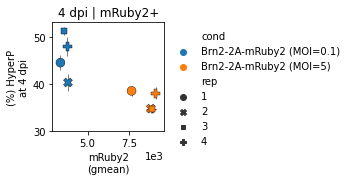

In [33]:
gate = 'mRuby2+'

# Calc mean and SEM
df1 = df_gmean_reps.copy()
df1 = df1[(df1.gate == gate) & (df1.cond != 'Ctrl-puro') & (df1.cond != 'mRuby2')]
group = ['cond', 'rep']
df1_mean = df1.groupby(group).mean().reset_index()
df1_SEM = df1.groupby(group).sem().reset_index()

# Calc mean and SEM for hyperP
df2 = data_4dpi_CTV_mRuby2_reps.copy()
df2 = df2[(df2.gate == gate) & (df2.cond != 'Ctrl-puro') & (df2.cond != 'mRuby2')]
df2_mean = df2.groupby(group).mean().reset_index()
df2_SEM = df2.groupby(group).sem().reset_index()

df_mean = pd.merge(df1_mean, df2_mean)
df_SEM = pd.merge(df1_SEM, df2_SEM)


hue = 'cond'
x = 'mRuby2-A (gmean)'
y = 'HyperP percent'
hue_order = ['Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']

palette = {
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'Brn2-2A-mRuby2\n(MOI=5)'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
sns.scatterplot(
    ax=ax, data=df_mean,
    hue=hue, hue_order=hue_order, style='rep',
    x=x, y=y, s=80,
    palette=palette, edgecolor='black', linewidth=0.4,)

# Error bars
ax.errorbar(
    x=df_mean[x], y=df_mean[y],
    xerr=df_SEM[x], yerr=df_SEM[y], 
    color='None', ecolor='black', elinewidth=0.5, zorder=-10)

# legend
sns.move_legend(ax,
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)


# Format axis
plt.title(f'4 dpi | {gate}')
# ax.set_ylim(0, 50)
# plt.xscale("symlog", linthresh=1e-5)
plt.xlabel('mRuby2\n(gmean)')
ax.yaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.set_yticks(np.arange(30, 60, 10))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Save fig
# plt.savefig(figpath + 'SI/scatterplt_hyperPpercent-v-mRuby2.svg', bbox_inches='tight')


# 14 dpi

## Load data

In [36]:
# Directories
base_datadir = rd.datadir/'2024.07.17_Brn2-MOI-titrate_14dpi_1-4'

# List of data folder names
dir_list = ['2024.07.17_Brn2-titrate_14dpi_1-2', '2024.07.19_Brn2-titrate_14dpi_3-4']  

ctrl_list = ['Ctrl-mRuby2', 'Ctrl-neg', 'Ctrl-puro']
cond_list = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)', 'Ctrl-puro']

# Store all data in list of dfs which will be converted to df at end
data_14dpi_singlets_all = list()
data_14dpi_mRuby2_all = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):
    
     # Load as df and note header is on 0th row
    df_singlets = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/dir_name/'well_metadata.yaml')
    df_mRuby2 = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_mRuby2', base_datadir/dir_name/'well_metadata.yaml')

    data_14dpi_singlets_all.append(df_singlets)
    data_14dpi_mRuby2_all.append(df_mRuby2)
    
    
# Convert list of dfs into single df
data_14dpi_singlets_all = pd.concat(data_14dpi_singlets_all, ignore_index=True)
data_14dpi_mRuby2_all = pd.concat(data_14dpi_mRuby2_all, ignore_index=True)
data_14dpi_singlets_all['gate'] = 'singlets'
data_14dpi_mRuby2_all['gate'] = 'mRuby2+'

# Remove negative data
data_14dpi_singlets_all = data_14dpi_singlets_all.loc[
    (data_14dpi_singlets_all['eGFP-A'] > 0) &
    (data_14dpi_singlets_all['mRuby2-A'] > 0)
]
data_14dpi_mRuby2_all = data_14dpi_mRuby2_all.loc[
    (data_14dpi_mRuby2_all['eGFP-A'] > 0) &
    (data_14dpi_mRuby2_all['mRuby2-A'] > 0)
]

# Separate out ctrl and sample data
data_14dpi_singlets_ctrl = data_14dpi_singlets_all[ data_14dpi_singlets_all['cond'].isin(ctrl_list) ]
data_14dpi_singlets = data_14dpi_singlets_all[ data_14dpi_singlets_all['cond'].isin(cond_list) ]
data_14dpi_mRuby2_ctrl = data_14dpi_mRuby2_all[ data_14dpi_mRuby2_all['cond'].isin(ctrl_list) ]
data_14dpi_mRuby2 = data_14dpi_mRuby2_all[ data_14dpi_mRuby2_all['cond'].isin(cond_list) ]

## Look at mRuby2

Distribution

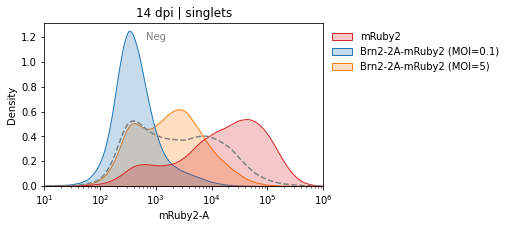

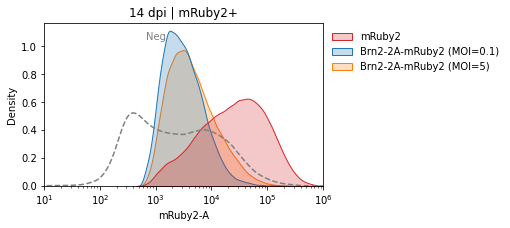

In [37]:
# What to plot
for gate in ['singlets', 'mRuby2+']:
    if gate == 'singlets':
        df = data_14dpi_singlets
    elif gate == 'mRuby2+':
        df = data_14dpi_mRuby2

    # Plot mRuby2-A
    x = 'mRuby2-A'
    hue = 'cond'
    hue_order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
    labels  = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
    palette = {
        'mRuby2': 'tab:red', 
        'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
        'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    f = sns.kdeplot(data=df,
        ax=ax, x=x, hue=hue,
        hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        palette=palette,
        fill=True)

    # Adjust labels
    sns.move_legend(ax,
        title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

    # Plot neg ctrl
    sns.kdeplot(data=data_14dpi_singlets_ctrl[(data_14dpi_singlets_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax.annotate('Neg', (0.4, 0.9), color='grey', xycoords='axes fraction', ha='center')
        
    # Adjust limits
    mRuby2_lim = (10, 1*10**6)
    ax.set_xlim(mRuby2_lim)

    # Save fig
    ax.set_title(f'14 dpi | {gate}')

What is mRuby2+ %?

In [38]:
# Calculate CTV populations using these metrics
group = ['rep', 'cond']
count_df_reps = data_14dpi_mRuby2.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count') # Puts 0 if none rather than dropping row
totalcount_df_reps = data_14dpi_singlets.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count') # Puts 0 if none rather than dropping row
mRuby2_percent_14dpi_reps = (count_df_reps*100/totalcount_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='percent')

# # Collapse bio reps
mRuby2_percent_14dpi = mRuby2_percent_14dpi_reps.groupby(group).mean().reset_index()

[Text(0, 0, 'mRuby2'),
 Text(1, 0, 'Brn2\n(MOI=0.1)'),
 Text(2, 0, 'Brn2\n(MOI=5)')]

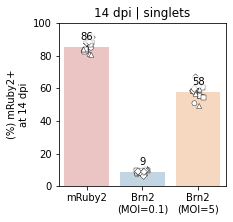

In [39]:
# General plotting params
x = 'cond'
y = 'percent'
order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Plot
sns.barplot(
    ax=ax, data=mRuby2_percent_14dpi_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(mRuby2_percent_14dpi_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=mRuby2_percent_14dpi_reps[mRuby2_percent_14dpi_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Label
ax.set_title(f'14 dpi | singlets')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) mRuby2+\nat 14 dpi')
ax.set_yticks(np.arange(0, 101, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

ax.set_xticklabels([label_dict[label] for label in order])

## Look at eGFP

### GFP gating

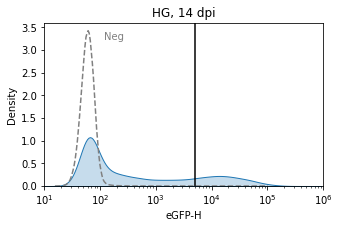

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Plot eGFP-H
x = 'eGFP-H'
sns.kdeplot(ax=ax,
    data=data_14dpi_singlets.loc[(data_14dpi_singlets['rep'] == 1) & (data_14dpi_singlets['cond'] == 'mRuby2')],
    x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot neg ctrl
sns.kdeplot(ax=ax,
    data=data_14dpi_singlets_ctrl[(data_14dpi_singlets_ctrl['cond'] == 'Ctrl-neg')],
    x=x, common_norm=False, log_scale=(True, False),
    color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')


# Plot threshold
ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Title
plt.title('HG, 14 dpi')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

Count eGFP+

In [41]:
# Categorize eGFP+ based on eGFP_thresh
data_14dpi_singlets.loc[:, 'eGFP_cat'] = 'eGFP-'
data_14dpi_singlets.loc[(data_14dpi_singlets['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'eGFP+'

# Get counts for eGFP +/-
group = ['gate', 'cond', 'rep']
count_GFP_df_reps = data_14dpi_singlets.groupby([*group, 'well', 'eGFP_cat'])['FSC-A'].count().unstack(fill_value=0).stack().rename('GFP count') # Puts 0 if no eGFP-H+ rather than dropping row
count_total_df_reps = data_14dpi_singlets.groupby([*group, 'well'])['FSC-A'].count().reset_index(name='Total count')
# Calc eGFP +/- percent and merge with counts
percent_GFP_df_reps = (count_GFP_df_reps*100/count_GFP_df_reps.groupby([*group, 'well']).transform('sum')).dropna().rename('GFP percent')
GFP_df_reps = pd.merge(percent_GFP_df_reps, count_GFP_df_reps, on=[*group, 'well', 'eGFP_cat']).reset_index()
# Calc yield from counts
numSeed = 10*1e3
GFP_df_reps['GFP yield'] = GFP_df_reps['GFP count']/numSeed*100
# Get just eGFP+
GFP_df_reps = GFP_df_reps.loc[GFP_df_reps.eGFP_cat == 'eGFP+']
GFP_df_reps = GFP_df_reps.merge(count_total_df_reps)

# Also get yield from 4 dpi data
singlets_4dpi_count_df_reps = data_4dpi_singlets.groupby([*group, 'well'])[
    'FSC-A'].count().reset_index(name='4 dpi count')
GFP_df_reps = GFP_df_reps.merge(singlets_4dpi_count_df_reps)
GFP_df_reps['GFP yield per 4 dpi gate'] = GFP_df_reps['GFP count']/GFP_df_reps['4 dpi count']*100


# Redo for mRuby2+
data_14dpi_mRuby2.loc[:, 'eGFP_cat'] = 'eGFP-'
data_14dpi_mRuby2.loc[(data_14dpi_mRuby2['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'eGFP+'
count_mRuby2_GFP_df_reps = data_14dpi_mRuby2.groupby([*group, 'well', 'eGFP_cat'])['FSC-A'].count().unstack(fill_value=0).stack().rename('GFP count') # Puts 0 if no eGFP-H+ rather than dropping row
count_mRuby2_total_df_reps = data_14dpi_mRuby2.groupby([*group, 'well'])['FSC-A'].count().reset_index(name='Total count')
percent_mRuby2_GFP_df_reps = (count_mRuby2_GFP_df_reps*100/count_mRuby2_GFP_df_reps.groupby([*group, 'well']).transform('sum')).dropna().rename('GFP percent')
GFP_mRuby2_df_reps = pd.merge(percent_mRuby2_GFP_df_reps, count_mRuby2_GFP_df_reps, on=[*group, 'well', 'eGFP_cat']).reset_index()
numSeed = 10*1e3
GFP_mRuby2_df_reps['GFP yield'] = GFP_mRuby2_df_reps['GFP count']/numSeed*100
GFP_mRuby2_df_reps = GFP_mRuby2_df_reps.loc[GFP_mRuby2_df_reps.eGFP_cat == 'eGFP+']
GFP_mRuby2_df_reps = GFP_mRuby2_df_reps.merge(count_mRuby2_total_df_reps)
mRuby2_4dpi_count_df_reps = data_4dpi_mRuby2.groupby([*group, 'well'])[
    'FSC-A'].count().reset_index(name='4 dpi count')
GFP_mRuby2_df_reps = GFP_mRuby2_df_reps.merge(mRuby2_4dpi_count_df_reps)
GFP_mRuby2_df_reps['GFP yield per 4 dpi gate'] = GFP_mRuby2_df_reps['GFP count']/GFP_df_reps['4 dpi count']*100


# Merge mRuby2+ and singlet dataframes together and get rid of Ctrl-puro (no mRuby2+)
data_14dpi_GFP_bothgates_reps = pd.concat([GFP_df_reps, GFP_mRuby2_df_reps])
data_14dpi_GFP_bothgates_reps = data_14dpi_GFP_bothgates_reps.loc[data_14dpi_GFP_bothgates_reps.cond != 'Ctrl-puro']

# Collapse bio reps
data_14dpi_GFP_bothgates = data_14dpi_GFP_bothgates_reps.groupby(group).mean(['GFP percent', 'GFP count', 'GFP yield']).reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Look at counts

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1)_singlets vs. Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+: t-test independent samples, P_val:6.995e-03 t=4.015e+00
mRuby2_singlets vs. mRuby2_mRuby2+: t-test independent samples, P_val:9.480e-01 t=6.797e-02
Brn2-2A-mRuby2 (MOI=5)_singlets vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:1.349e-01 t=1.727e+00
Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:5.644e-01 t=6.097e-01


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


Text(0.5, 1.0, '14 dpi')

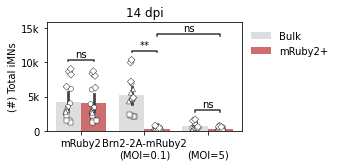

In [43]:
# Plotting params
x = 'cond'
y = 'GFP count'
hue = 'gate'

order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
hue_order = ['singlets', 'mRuby2+']
label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'\n(MOI=5)'}


palette = {'singlets': 'lightgrey',
            'mRuby2+': 'tab:red'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

for (i, rep) in enumerate(data_14dpi_GFP_bothgates_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_14dpi_GFP_bothgates_reps[data_14dpi_GFP_bothgates_reps.rep == rep],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'singlets': 'white', 'mRuby2+': 'white'}, size=5,
        edgecolor='black', linewidth=0.4)

# Plot as box
sns.barplot(ax=ax,
    data=data_14dpi_GFP_bothgates_reps, 
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order, 
    palette=palette, alpha=0.75)

# Adjust labels
lmap = {'singlets':'Bulk', 'mRuby2+':'mRuby2+'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_xlabel('')
ax.yaxis.set_label_text('(#) Total iMNs')
# ax.set_yticks(np.arange(0, 41, 10))
ax.set_xticklabels([label_dict[label] for label in order])

k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'singlets'), (cond, 'mRuby2+')) for cond in order]
pairs.append((('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+')))

annot = Annotator(ax=ax,
    data=data_14dpi_GFP_bothgates, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

plt.title('14 dpi')

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1)_singlets vs. Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+: t-test independent samples, P_val:2.525e-02 t=2.961e+00
mRuby2_singlets vs. mRuby2_mRuby2+: t-test independent samples, P_val:9.312e-01 t=-8.996e-02
Brn2-2A-mRuby2 (MOI=5)_singlets vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:1.759e-01 t=1.534e+00
Brn2-2A-mRuby2 (MOI=0.1)_mRuby2+ vs. Brn2-2A-mRuby2 (MOI=5)_mRuby2+: t-test independent samples, P_val:4.755e-01 t=-7.610e-01


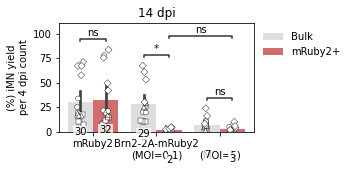

In [44]:
# Plotting params
x = 'cond'
y = 'GFP yield per 4 dpi gate'
hue = 'gate'

order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
hue_order = ['singlets', 'mRuby2+']
label_dict = {
    'mRuby2': 'mRuby2', 
    'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2-2A-mRuby2\n(MOI=0.1)', 
    'Brn2-2A-mRuby2 (MOI=5)':'\n(MOI=5)'}


palette = {'singlets': 'lightgrey',
            'mRuby2+': 'tab:red'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

for (i, rep) in enumerate(data_14dpi_GFP_bothgates_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_14dpi_GFP_bothgates_reps[data_14dpi_GFP_bothgates_reps.rep == rep],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'singlets': 'white', 'mRuby2+': 'white'}, size=5,
        edgecolor='black', linewidth=0.4)

# Plot as box
sns.barplot(ax=ax,
    data=data_14dpi_GFP_bothgates_reps, 
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order, 
    palette=palette, alpha=0.75)

# Adjust labels
lmap = {'singlets':'Bulk', 'mRuby2+':'mRuby2+'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=-35)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN yield\nper 4 dpi count')
# ax.set_yticks(np.arange(0, 41, 10))
ax.set_xticklabels([label_dict[label] for label in order])

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'singlets'), (cond, 'mRuby2+')) for cond in order]
pairs.append((('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2+'), ('Brn2-2A-mRuby2 (MOI=5)', 'mRuby2+')))

annot = Annotator(ax=ax,
    data=data_14dpi_GFP_bothgates, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

plt.title('14 dpi')
# plt.savefig(figpath + '14dpi_GFPyieldper4dpi-singlets-v-mRuby2+_alt.svg', bbox_inches='tight')

Just normal yield

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1) vs. Brn2-2A-mRuby2 (MOI=5): t-test independent samples, P_val:1.009e-02 t=3.700e+00
mRuby2 vs. Brn2-2A-mRuby2 (MOI=0.1): t-test independent samples, P_val:6.116e-01 t=-5.355e-01
mRuby2 vs. Brn2-2A-mRuby2 (MOI=5): t-test independent samples, P_val:4.571e-02 t=2.513e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


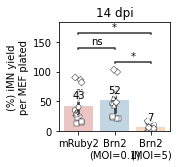

In [45]:
# General plotting params
x = 'cond'
y = 'GFP yield'
order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
# Plot
df_reps = data_14dpi_GFP_bothgates_reps.loc[data_14dpi_GFP_bothgates_reps.gate == 'singlets']
df = data_14dpi_GFP_bothgates.loc[data_14dpi_GFP_bothgates.gate == 'singlets']

sns.barplot(
    ax=ax, data=df_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(df_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=df_reps[df_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Add in stats
# Pairs for stats comp
pairs = [
    ('Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)'),
    ('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2'),
    ('mRuby2', 'Brn2-2A-mRuby2 (MOI=5)')
]
annot = Annotator(ax=ax,
    data=df, pairs=pairs,
    x=x, y=y,
    order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

# Label
ax.set_title(f'14 dpi')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
# ax.set_yticks(np.arange(0, 90, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1) vs. Brn2-2A-mRuby2 (MOI=5): t-test independent samples, P_val:8.203e-05 t=4.553e+00
mRuby2 vs. Brn2-2A-mRuby2 (MOI=0.1): t-test independent samples, P_val:8.090e-01 t=2.440e-01
mRuby2 vs. Brn2-2A-mRuby2 (MOI=5): t-test independent samples, P_val:6.047e-04 t=3.847e+00


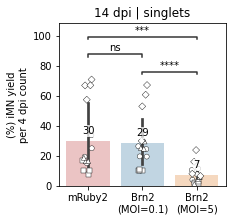

In [46]:
# General plotting params
x = 'cond'
y = 'GFP yield per 4 dpi gate'
order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# Plot
gate = 'singlets'
df_reps = data_14dpi_GFP_bothgates_reps.loc[data_14dpi_GFP_bothgates_reps.gate == gate]
df = data_14dpi_GFP_bothgates.loc[data_14dpi_GFP_bothgates.gate == gate]

sns.barplot(
    ax=ax, data=df_reps,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(df_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=df_reps[df_reps.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Add in stats
# Pairs for stats comp
pairs = [
    ('Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)'),
    ('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2'),
    ('mRuby2', 'Brn2-2A-mRuby2 (MOI=5)')
]
annot = Annotator(ax=ax,
    data=df_reps, pairs=pairs,
    x=x, y=y,
    order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

# Label
ax.set_title(f'14 dpi | {gate}')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) iMN yield\nper 4 dpi count')
# ax.set_yticks(np.arange(0, 90, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

## What if instead look at the fraction of eGFP+ cells that are mRuby2?

In [47]:
df1 = GFP_mRuby2_df_reps.loc[:, ['cond', 'rep', 'well', 'GFP count']]
df2= GFP_df_reps.loc[:, ['cond', 'rep', 'well', 'GFP count']]

df1.rename(columns={'GFP count': 'mRuby2 and GFP count'}, inplace=True)
df2.rename(columns={'GFP count': 'Total GFP count'}, inplace=True)

df3 = df1.merge(df2)
df3.loc[:,'percent mRuby2 of GFP'] = df3['mRuby2 and GFP count']/df3['Total GFP count']*100

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Brn2-2A-mRuby2 (MOI=0.1) vs. Brn2-2A-mRuby2 (MOI=5): t-test independent samples, P_val:6.721e-12 t=-1.084e+01
mRuby2 vs. Brn2-2A-mRuby2 (MOI=0.1): t-test independent samples, P_val:4.957e-42 t=1.338e+02
mRuby2 vs. Brn2-2A-mRuby2 (MOI=5): t-test independent samples, P_val:6.994e-17 t=1.739e+01


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


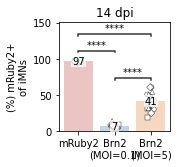

In [48]:
# General plotting params
x = 'cond'
y = 'percent mRuby2 of GFP'
order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']    
palette = {
    'Ctrl-puro': 'grey',
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}
label_dict = {'Ctrl-puro': 'Ctrl-puro',
    'mRuby2': 'mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)':'Brn2\n(MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)':'Brn2\n(MOI=5)'}


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
# Plot
df = df3
sns.barplot(
    ax=ax, data=df,
    x=x, y=y,
    order=order, units=units, 
    palette=palette, alpha=0.3)

# Plot bio tech reps
for (j, rep) in enumerate(df.rep.unique()):
    sns.stripplot(
        ax=ax, data=df[df.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[j],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Add in stats
# Pairs for stats comp
pairs = [
    ('Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)'),
    ('Brn2-2A-mRuby2 (MOI=0.1)', 'mRuby2'),
    ('mRuby2', 'Brn2-2A-mRuby2 (MOI=5)')
]
annot = Annotator(ax=ax,
    data=df, pairs=pairs,
    x=x, y=y,
    order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

# Label
ax.set_title(f'14 dpi')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) mRuby2+\nof iMNs')
# ax.set_yticks(np.arange(0, 90, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=-5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

## Plot iMN yield vs. hyperP

In [49]:
df_4dpi_14pi_reps = pd.merge(data_4dpi_CTV_bothgates_reps,data_14dpi_GFP_bothgates_reps, on=['gate', 'cond', 'rep', 'well'])

# Calc mean and SEM for each cond
# group = ['gate', 'cond', 'rep']
group = ['gate', 'cond']
df_4dpi_14pi_mean = df_4dpi_14pi_reps.groupby(group).mean().reset_index()
df_4dpi_14pi_SEM =df_4dpi_14pi_reps.groupby(group).sem().reset_index()

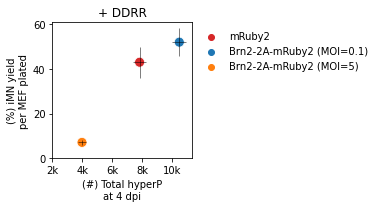

In [50]:
# Plotting params
x = 'HyperP count'
y = 'GFP yield'
hue = 'cond'
hue_order = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
labels  = ['mRuby2', 'Brn2-2A-mRuby2 (MOI=0.1)', 'Brn2-2A-mRuby2 (MOI=5)']
palette = {
    'Ctrl-puro': 'grey', 
    'mRuby2': 'tab:red', 
    'Brn2-2A-mRuby2 (MOI=0.1)': 'tab:blue',
    'Brn2-2A-mRuby2 (MOI=5)': 'tab:orange'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

gate = 'singlets'
df_mean = df_4dpi_14pi_mean.loc[df_4dpi_14pi_mean.gate == gate]
df_SEM = df_4dpi_14pi_SEM.loc[df_4dpi_14pi_SEM.gate == gate]
            
f = sns.scatterplot(ax=ax,
    data=df_mean,
    x=x, y=y, hue=hue, hue_order=hue_order,
    s=100, palette=palette)
ax.errorbar(x=df_mean[x], y=df_mean[y],
            xerr=df_SEM[x], yerr=df_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)

# Format
sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

ax.set_yticks(np.arange(0, 80, 20))
ax.set_xticks(np.arange(2e3, 11e3, 2e3))

k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.xaxis.set_major_formatter(k_formatter)
ax.xaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
plt.title('+ DDRR')

plt.savefig(figpath + '14dpi_YieldvHyperPcount-bigger.svg', bbox_inches='tight')
